## Etapa 1: Inicialização da Imagem

In [1]:
# Inicialização
%matplotlib inline
import matplotlib
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import HTML
import numpy as np
from PIL import Image, ImageEnhance
import requests
import seaborn as sns
from io import BytesIO
from copy import deepcopy
from scipy.spatial import distance
from scipy.interpolate import UnivariateSpline
from copy import deepcopy

# Defaults pra figuras
matplotlib.rcParams['figure.figsize'] = (6,6)
matplotlib.rcParams['image.aspect'] = 'equal'

In [2]:
class ImageObject:
    def __init__(self, url):
        self.url = url
        response = requests.get(url)
        self.img = Image.open(BytesIO(response.content))
        self.og_size = self.img.size
    
    def show(self):
        imshow(np.asarray(self.img))

    def monochrome(self, scale=3, threshold=200):
        
        # conversão da imagem para monocromático
        image = self.img.convert('L')
        image_array = np.array(image)
        for i in range(len(image_array)):
            for j in range(len(image_array[0])):
                if image_array[i][j] > threshold:
                    image_array[i][j] = 255
                else:
                    image_array[i][j] = 0
        image = Image.fromarray(image_array)
        
        img_sm = image.resize(tuple([int(v/scale) for v in image.size]),Image.ANTIALIAS)
        
        # conversão da imagem para preto e branco
        img_bw = img_sm.convert(mode='1', dither=2) 
        self.bw_img = img_bw
        self.pixels = (1 - np.asarray(img_bw).astype(int))
        self.pixels_flat = np.reshape(self.pixels, self.pixels.size)
    
    def show_bw(self):
        print("Dimensions: {}".format(self.bw_img.size))
        print("Num. pixels: {}".format(self.pixels.sum()))
        imshow(np.asarray(self.bw_img))
    
    def get_tour(self, starting_point="random", plot=True):
        absolute_index = np.where(self.pixels_flat > 0)[0] # positions of non-zero pixels
        relative_index = np.array(range(1, len(absolute_index)+1 ))
        
        flat_img_mod = deepcopy(self.pixels_flat)
        for rel, pix in enumerate(absolute_index):
            flat_img_mod[pix] = rel+1
        
        # pegar coordenadas de cada pixel diferente de zero
        img_idx = np.reshape(flat_img_mod, self.pixels.shape)
        self.coord_list = []
        for p1 in relative_index:
            p1_coords = tuple([int(c) for c in np.where(img_idx==p1)])
            self.coord_list.append(list(p1_coords))
        
        # calcular a distância entre cada par de cordas
        dist_mat = distance.cdist(self.coord_list, self.coord_list, 'euclidean')

        # inicializar espaço de busca
        cities = self.coord_list
        num_cities = len(cities)
        if starting_point=="random":
            start = int(np.random.choice(range(num_cities),size=1))
        else:
            assert starting_point < num_cities
            start = starting_point
        tour = [start]
        active_city = start
        for step in range(0, num_cities):
            dist_row = deepcopy(dist_mat[active_city,:])
            for done in tour:
                dist_row[done] = np.inf
            nearest_neighbor = np.argmin(dist_row)
            if nearest_neighbor not in tour:
                tour.append(nearest_neighbor)
            active_city = nearest_neighbor

        y_tour = -np.array([cities[tour[i % num_cities]] for i in range(num_cities+1) ])[:,0]
        y_tour = y_tour - y_tour[0]#- min(y_tour)
        x_tour = np.array([cities[tour[i % num_cities]] for i in range(num_cities+1) ])[:,1]    
        x_tour = x_tour - x_tour[0]#- min(x_tour)
        
        np.append(x_tour, x_tour[0])
        np.append(y_tour, y_tour[0])
        num_cities = num_cities + 1
    
        self.x_tour = x_tour
        self.y_tour = y_tour
        self.num_pixels = num_cities
        
        if plot:
            plt.plot(self.x_tour, self.y_tour)
            
    def get_splines(self, degree=1, plot=True):
        # conversão para splines
        x_spl = UnivariateSpline(list(range(0,self.num_pixels)), self.x_tour, k=degree)
        y_spl = UnivariateSpline(list(range(0,self.num_pixels)), self.y_tour, k=degree)
        
        self.x_spl = x_spl
        self.y_spl = y_spl
        
        if plot:
            p = plt.plot(*zip(*[(x_spl(v), y_spl(v)) for v in np.linspace(0, self.num_pixels-1, 1000)]))

            
    def plot_parametric(self, num_points=1000):
        t_vals, x_vals = zip(*[
            (v, self.x_spl(v)) for v in np.linspace(0, self.num_pixels, num_points)
        ])
        x_vals = np.array(x_vals)
        y_vals = np.array([self.y_spl(v) for v in np.linspace(0, self.num_pixels, num_points)])
        t_vals = np.array(t_vals)

        plt.plot(t_vals, x_vals)
        plt.plot(t_vals, y_vals)

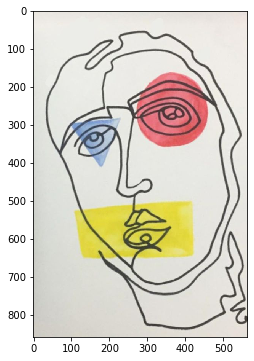

In [3]:
# Imagens do pinterest
url = "http://thevirtualinstructor.com/images/continuouslinedrawinghorse.jpg"
url2 = "https://i.pinimg.com/564x/a8/77/f6/a877f6e80f08953bb0523d92be91b181.jpg"
url3 = "https://i.pinimg.com/564x/1a/85/d7/1a85d768b1e073843f0656c02eea3a8b.jpg"
julia = ImageObject(url3)
julia.show()

Dimensions: (376, 572)
Num. pixels: 16985


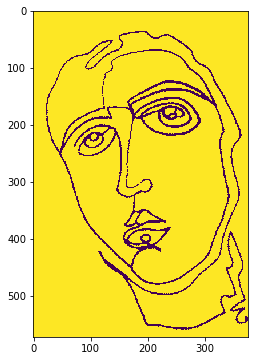

In [4]:
julia.monochrome(scale=1.5, threshold=110)
julia.show_bw()

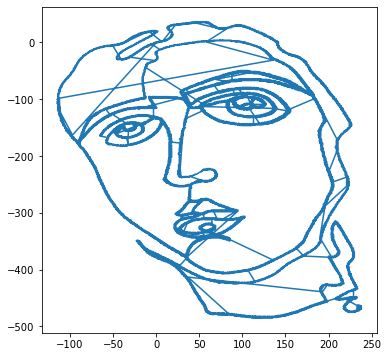

In [5]:
julia.get_tour(starting_point=800)

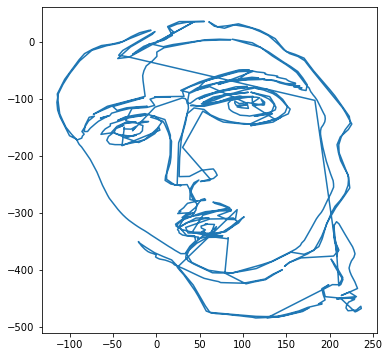

In [6]:
julia.get_splines()

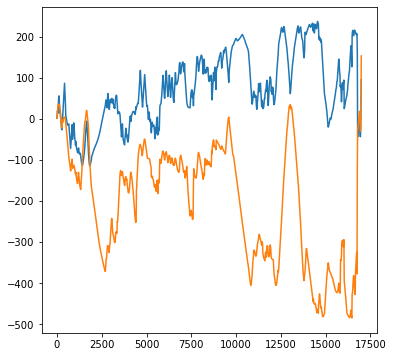

In [7]:
# plot paramétrico de x e y
julia.plot_parametric()

## Etapa 2: Cálculo de Amplitudes de Fourier

In [8]:
class FourierTransform:
    def __init__(self,
            fxn, 
            rnge, 
            N=1000,  
            period=None, 
            num_points=2000, 
            num_circles=80 
        ):
        
        self.num_circles = num_circles
        
        t_vals, y = zip(*[(v, fxn(v)) for v in np.linspace(rnge[0], rnge[1]-1, num_points)])
        t_vals = np.array(t_vals)        
        self.t_vals = t_vals
        
        y = np.array(y)
        y = y - y[0]
        self.fxn_vals = np.array(deepcopy(y))

        endpoint = np.mean([y[0], y[-1]])
        y[0] = endpoint
        y[-1] = endpoint
        
        y = y - y[0]
        
        self.N = N
        if period==None:
            period = rnge[1]
        self.period = period
            
        def cn(n):
            c = y*np.exp(-1j*2*n*np.pi*t_vals/period)
            return(c.sum()/c.size)

        coefs = [cn(i) for i in range(1,N+1)]
        self.coefs = coefs
        self.real_coefs = [c.real for c in self.coefs]
        self.imag_coefs = [c.imag for c in self.coefs]
        
        self.amplitudes = np.absolute(self.coefs)
        self.phases = np.angle(self.coefs)
        
        
        def f(x, degree=N):
            f = np.array([2*coefs[i-1]*np.exp(1j*2*i*np.pi*x/period) for i in range(1,degree+1)])
            return(f.sum())
        
        fourier_approximation = np.array([f(t, degree=N).real for t in t_vals])
        circles_approximation = np.array([f(t, degree=self.num_circles).real for t in t_vals])
        
        fourier_approximation = fourier_approximation - (fourier_approximation - self.fxn_vals).mean()
        
        circles_approximation = circles_approximation - (circles_approximation - self.fxn_vals).mean()
        self.circles_approximation = circles_approximation
        
        self.origin_offset = fourier_approximation[0] - self.fxn_vals[0]

        self.circles_approximation_offset = circles_approximation[0] - self.fxn_vals[0]
        
        self.fourier_approximation = fourier_approximation

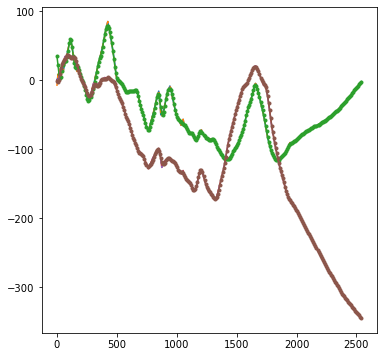

In [9]:
NC = 300
xFT = FourierTransform(julia.x_spl, (0, julia.num_pixels), num_circles=NC)
yFT = FourierTransform(julia.y_spl, (0, julia.num_pixels), num_circles=NC)

R = 300
plt.plot(xFT.t_vals[0:R], xFT.fxn_vals[0:R])
plt.plot(xFT.t_vals[0:R], xFT.fourier_approximation[0:R], "--")
plt.plot(xFT.t_vals[0:R], xFT.circles_approximation[0:R], ".-")

plt.plot(yFT.t_vals[0:R], yFT.fxn_vals[0:R])
plt.plot(yFT.t_vals[0:R], yFT.fourier_approximation[0:R], "--")
plt.plot(yFT.t_vals[0:R], yFT.circles_approximation[0:R], ".-")

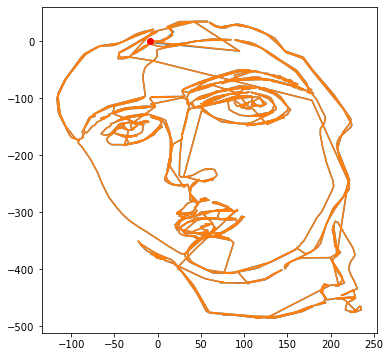

In [10]:
plt.plot(xFT.fxn_vals, yFT.fxn_vals)
plt.plot(xFT.fourier_approximation, yFT.fourier_approximation)
plt.plot(xFT.fourier_approximation[0], yFT.fourier_approximation[0], 'o', color='red')

In [11]:
class ComplexCircles:
    # Produz a visualização de círculos complexos de Fourier
    def __init__(self,
                 FT,
                 num_circles=20, 
                 t_init=0, 
                 origin=(0, 0) 
        ):
        self.FT = FT
        self.t_init = t_init
        self.num_circles = num_circles
        self.origin = origin
        self.origin_x = origin[0]
        self.origin_y = origin[1]
        self.t_elapsed = 0
        self.steps_elapsed = 0
        self.t_current = self.t_init
        self.t_index_current = 0
        self.true_fxn_val_current = self.FT.fxn_vals[t_init]
        self.fourier_approx_val_current = self.FT.fourier_approximation[t_init]
        
        self.Xs = []
        self.Ys = [] 
        
        self.As = FT.amplitudes[0:num_circles] 
        self.Zs = FT.phases[0:num_circles] 
    
    def circle_positions(self, transpose=False):
        num_circles = self.num_circles
        t = self.t_current
        
        running_x_offset = deepcopy(self.origin_x)
        running_y_offset = deepcopy(self.origin_y)

        radii = []
        x_centers = [deepcopy(self.origin_x)]
        y_centers = [deepcopy(self.origin_y)]
        
        for i in range(0,num_circles):
            freq = i+1 
            a = self.As[i] 
            z = self.Zs[i]

            radius = 2*a
            radii.append(radius)
            
            running_x_offset += 2*a*np.cos(t*2*np.pi*freq/self.FT.period + z)
            running_y_offset += 2*a*np.sin(t*2*np.pi*freq/self.FT.period + z)
            
            if i < num_circles-1:
                x_centers.append(running_x_offset)
                y_centers.append(running_y_offset)
            
        if t==0:
            self.circles_offset = running_x_offset
        radii = np.array(radii)
        x_centers = np.array(x_centers) - self.circles_offset + self.FT.origin_offset
        y_centers = np.array(y_centers)
        
        x_final = running_x_offset - self.circles_offset + self.FT.origin_offset
        y_final = running_y_offset
        
        self.Xs.append(x_final)
        self.Ys.append(y_final)
        
        if transpose:
            return(radii, -y_centers, x_centers, -y_final, x_final)
        return(radii, x_centers, y_centers, x_final, y_final)
    
    
    def get_circles(self, transpose=False):
        return(self.circle_positions(transpose=transpose))
    
    def step(self, dt=1):
        self.steps_elapsed += 1
        next_index = dt*self.steps_elapsed 
        if next_index > len(self.FT.t_vals)-1:
            print("tempo esgotado")
            self.steps_elapsed -= 1
        else:
            self.t_current = self.FT.t_vals[next_index]
            self.t_elapsed = self.t_current - self.t_init
            self.t_index_current = next_index
            self.true_fxn_val_current = self.FT.fxn_vals[next_index]
            self.fourier_approx_val_current = self.FT.fourier_approximation[next_index]

In [12]:
x_spl = julia.x_spl
y_spl = julia.y_spl
num_pixels = julia.num_pixels

num_circles = 100

anim_length = 20
fps = 24 
num_frames = anim_length*fps
interval = (1./fps)*1000

dt = (int(2000. / num_frames) + 1)
num_points =  dt* num_frames
xFT = FourierTransform(x_spl, (0, num_pixels), num_points=num_points, N=num_circles)
yFT = FourierTransform(y_spl, (0, num_pixels), num_points=num_points, N=num_circles)

X_circles_spacing = 300
Y_circles_spacing = 400

x_main_offset = xFT.origin_offset
y_main_offset = yFT.origin_offset
x_origin = (0, X_circles_spacing)
#y_origin = (circles_spacing, y_main_offset)
y_origin = (0, Y_circles_spacing)
#y_origin = (0,0)



In [13]:
approx_coords = np.array(list(zip(xFT.fourier_approximation, yFT.fourier_approximation)))
og_coords = np.array(list(zip(julia.x_tour, julia.y_tour)))
approx_dist = distance.cdist(approx_coords, og_coords, 'euclidean')
closest_points = approx_dist.min(1)
def alpha_fxn(d):
    return(np.exp(-(1/10)*d))
    heights = hist[0]
    scaled_h = heights/heights[0]
    breaks = hist[1]
    for i, b in enumerate(breaks[1:]):
        if d < b:
            return(scaled_h[i])
    
cutoff = int(len(closest_points)*.95)
alpha_vals = [ alpha_fxn(p) if i < cutoff else 0.33 for i, p in enumerate(closest_points) ]

Max t-value reached
Max t-value reached


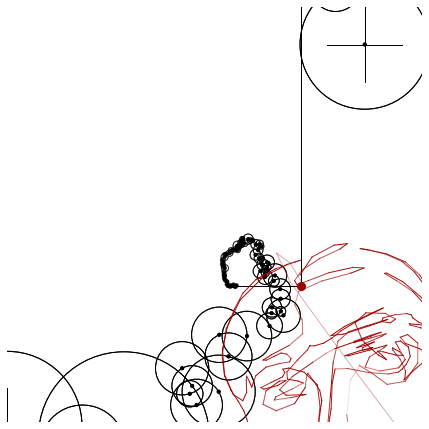

In [14]:
xCircles = ComplexCircles(xFT, num_circles=num_circles, origin=x_origin)
yCircles = ComplexCircles(yFT, num_circles=num_circles, origin=y_origin)

fig = plt.figure()

plt.axis([-400,150,-200,350])

ax = plt.gca()
ax.set_aspect(1)
ax.set_facecolor('#f9f9f9')
ax.set_yticklabels([])
plt.tight_layout(pad=0)
plt.axis('off')

circle_color = 'black'
drawing_color = '#9c0200'

alphas = np.linspace(1, 0.25, num_circles) 
X_circle_objs = []
X_center_objs = []
Y_circle_objs = []
Y_center_objs = []

X_radii, X_x_centers, X_y_centers, X_x_final, X_y_final = xCircles.get_circles()
Y_radii, Y_x_centers, Y_y_centers, Y_x_final, Y_y_final = yCircles.get_circles(transpose=True)


for c in range(0,num_circles):
    Xcirc = plt.Circle((X_x_centers[c], X_y_centers[c]), radius=X_radii[c],
                      edgecolor=circle_color, facecolor='None', alpha=alphas[c])
    X_circle_objs.append(Xcirc)
    Xcenter = plt.Circle((X_x_centers[c], X_y_centers[c]), radius=2,
                      edgecolor=circle_color, facecolor=circle_color, alpha=alphas[c])
    X_center_objs.append(Xcenter)
    
    
    Ycirc = plt.Circle((Y_x_centers[c], Y_y_centers[c]), radius=Y_radii[c],
                      edgecolor=circle_color, facecolor='None', alpha=alphas[c])
    Y_circle_objs.append(Ycirc)
    Ycenter = plt.Circle((Y_x_centers[c], Y_y_centers[c]), radius=2,
                      edgecolor=circle_color, facecolor=circle_color, alpha=alphas[c])
    Y_center_objs.append(Ycenter)

X_connector_line, = ax.plot([], [], '-', lw=1, color='black')
Y_connector_line, = ax.plot([], [], '-', lw=1, color='black') 

trace_point, = ax.plot([], [], 'o', markersize=8, color=drawing_color)

drawing_segments = []
for idx in range(len(xFT.t_vals)):
    segment, = ax.plot([-1000, -1001], [-1000,-1001], '-', lw=1, color=drawing_color, alpha=alpha_vals[idx])
    drawing_segments.append(segment)
segment, = ax.plot([-1000,-1001], [-1000,-1001], '-', lw=1, color=drawing_color, alpha=alpha_vals[0])
drawing_segments.append(segment)

x_main_offset = X_x_centers[0]
y_main_offset = Y_y_centers[0]

axis_length = 50
axis_style = {
    "linestyle": "solid",
    "linewidth": 1,
    "color": "black"
}
x_x_axis = ax.plot(
    [x_main_offset-axis_length, x_main_offset+axis_length], 
    [X_circles_spacing,X_circles_spacing],
    **axis_style
)
x_y_axis = ax.plot(
    [x_main_offset, x_main_offset], 
    [X_circles_spacing-axis_length,X_circles_spacing+axis_length],
    **axis_style
)
y_x_axis = ax.plot(
    [-Y_circles_spacing-axis_length, -Y_circles_spacing+axis_length],
    [y_main_offset, y_main_offset], 
    **axis_style
)
y_y_axis = ax.plot(
    [-Y_circles_spacing, -Y_circles_spacing],
    [y_main_offset-axis_length, y_main_offset+axis_length], 
    **axis_style
)


def init():
    for idx in range(len(xFT.t_vals)):
        drawing_segments[idx].set_data([],[])
    
    X_connector_line.set_data([], [])
    Y_connector_line.set_data([], [])
    trace_point.set_data([], [])
    for c in range(num_circles):
        ax.add_patch(X_circle_objs[c])
        ax.add_patch(X_center_objs[c])
        ax.add_patch(Y_circle_objs[c])
        ax.add_patch(Y_center_objs[c])
    return([])

def animate(i):
        
    X_radii, X_x_centers, X_y_centers, X_x_final, X_y_final = xCircles.get_circles()
    Y_radii, Y_x_centers, Y_y_centers, Y_x_final, Y_y_final = yCircles.get_circles(transpose=True)
    
    for c in range(0,num_circles):
        X_circle_objs[c].center = (X_x_centers[c], X_y_centers[c])
        X_center_objs[c].center = (X_x_centers[c], X_y_centers[c])

        Y_circle_objs[c].center = (Y_x_centers[c], Y_y_centers[c])
        Y_center_objs[c].center = (Y_x_centers[c], Y_y_centers[c])

    idx_current = xCircles.t_index_current
    x_true_current = deepcopy(xCircles.fourier_approx_val_current)
    y_true_current = deepcopy(yCircles.fourier_approx_val_current)
    X_connector_line.set_data(
        [x_true_current, x_true_current], 
        [y_true_current, X_y_final]
    )
    Y_connector_line.set_data(
        [Y_x_final, x_true_current], [y_true_current, y_true_current]
    )
    trace_point.set_data([x_true_current], [y_true_current])

    xCircles.step(dt=dt)
    yCircles.step(dt=dt)

    drawing_segments[idx_current].set_data(
        [x_true_current, xCircles.fourier_approx_val_current], 
        [y_true_current, yCircles.fourier_approx_val_current]
    )

    
    return([])

ani = animation.FuncAnimation(fig, animate, frames=num_frames,
                              interval=interval, blit=True, init_func=init)

from IPython.display import Image as DisplayImage
ani.save('./animation4.gif', writer='imagemagick')
DisplayImage(url='./animation4.gif')